<span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">⚡ Electricity Production Forecasting ⚡</span>

1. [Libraries and Utilities](#1)
2. [Loading Data](#2)
3. [Rolling Statistics](#3)
4. [Checking Stationarity](#4)
    - [Mean of Data](#5)
    - [Variance of Data](#6)
    - [Augmented Dickey-Fuller Test](#7)
5. [Converting Data to Stationary](#8)
    - [Logarithmic Transformation with Box-Cox](#9)
    - [Removing Trend with Moving Average](#10)
    - [Exponential Decay Transformation](#11)
6. [Decomposition](#12)
7. [ACF & PACF](#13)
8. [Forecasting Models](#14)
    - [Persistence Model](#15)
    - [Autoregression Model](#16)
    - [Moving Average Model](#17)
    - [ARIMA Model](#18)
    - [Mean Squared Errors](#19)

<a id = "1"></a><h1 id="Libraries and Utilities"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Libraries and Utilities</span></h1>

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id = "2"></a><h1 id="Loading Data"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Loading Data</span></h1>

In [2]:

col_names = ["date", "value"]
df = pd.read_csv("Electric_Production.csv",
                 names = col_names, header = 0, parse_dates = [0])
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df = df.set_index(['date'])
df.head()

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


<a id = "3"></a><h1 id="Rolling Statistics"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Rolling Statistics</span></h1>


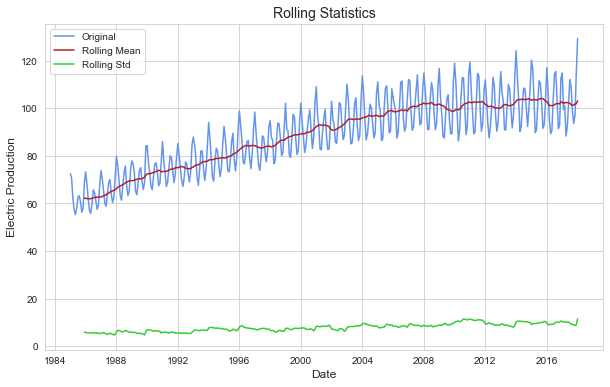

In [3]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

<a id = "4"></a><h1 id="Checking Stationarity"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Checking Stationarity</span></h1>

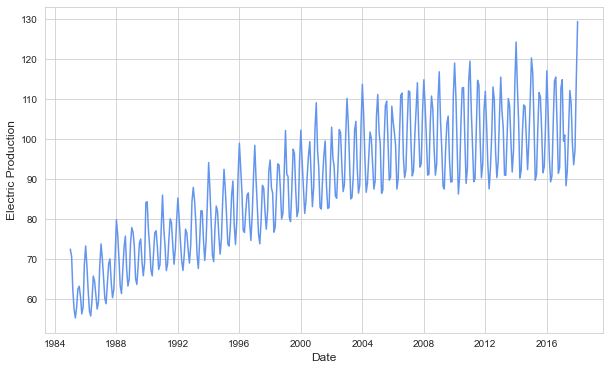

In [4]:
plt.figure(figsize = (10,6))
plt.plot(df['value'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

Looking at the plot we can observe there is an **upward trend** over the period of time.

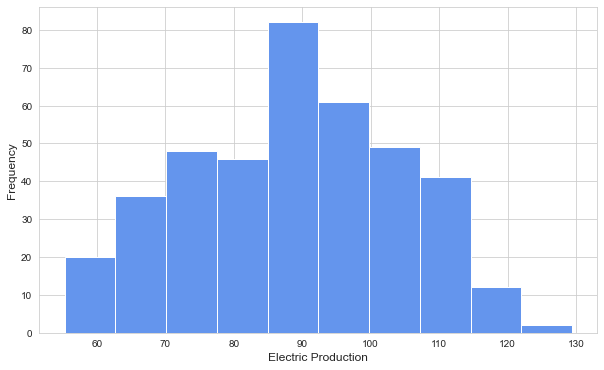

In [5]:
plt.figure(figsize = (10,6))
plt.hist(df['value'], color = 'cornflowerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

In [6]:
print("Data Shape: {}".format(df.shape))
value_1 = df[0:199]
value_2 = df[200:397]

Data Shape: (397, 1)


We will proceed by splitting the data into two parts so that we can then check the **mean** and **variance** of the data.

<a id = "5"></a><h1 id="Mean of Data"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Mean of Data</p></h1>

In [7]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))
print("Mean of value_2: {}".format(round(value_2.mean()[0],3)))

Mean of value_1: 77.497
Mean of value_2: 100.258


<a id = "6"></a><h1 id="Variance"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Variance of Data</p></h1>

In [8]:
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Variance of value_1: 123.226
Variance of value_2: 91.677


<a id = "7"></a><h1 id="Augmented Dickey-Fuller Test"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Augmented Dickey-Fuller Test</p></h1>



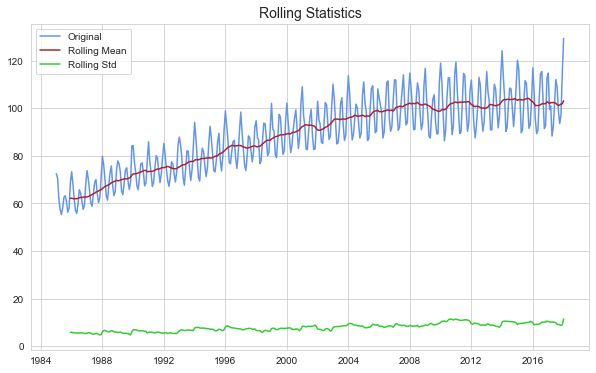

ADF Statistic: -2.257
p-value: 0.186
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [9]:
def adfuller_test(ts, window = 12):
    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)
    
    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window = 12)

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact **non-stationary**.

<a id = "8"></a><h1 id="Converting Data to Stationary"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Converting Data to Stationary</span></h1>
<a id = "9"></a><h1 id="Logarithmic Transformation with Box-Cox"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Logarithmic Transformation with Box-Cox</p></h1>


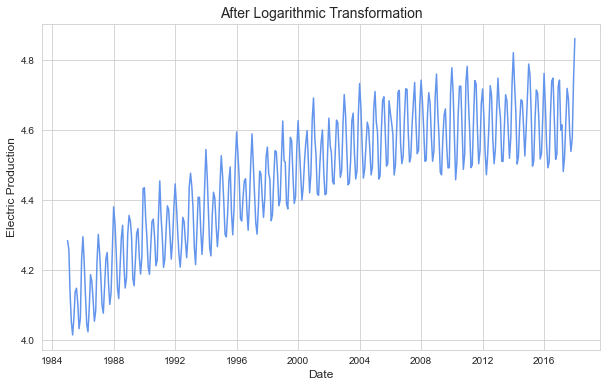

In [10]:
df_log_scaled = df
df_log_scaled['value'] = boxcox(df_log_scaled['value'], lmbda=0.0)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Logarithmic Transformation", size = 14)
plt.show()

<a id = "10"></a><h1 id="Removing Trend with Moving Average"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Removing Trend with Moving Average</p></h1>



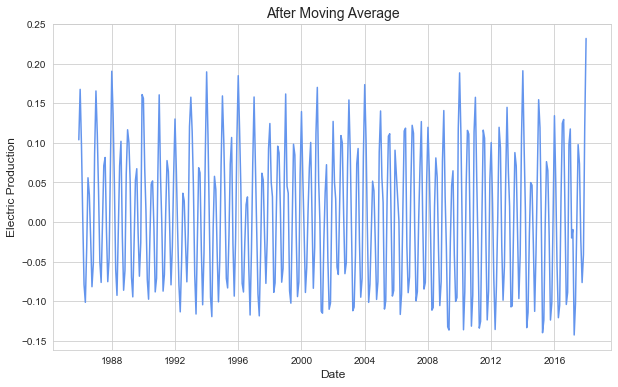

In [11]:
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace=True)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

<a id = "11"></a><h1 id="Exponential Decay Transformation"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Exponential Decay Transformation</p></h1>

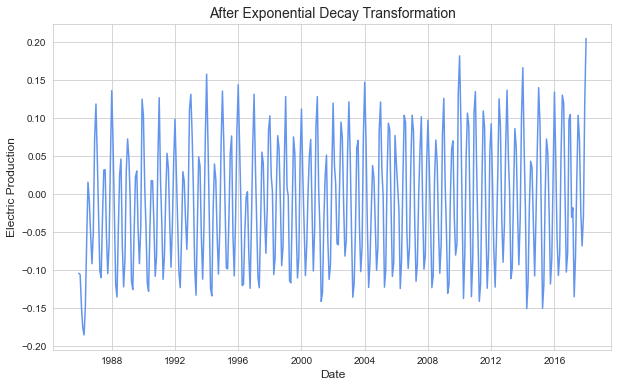

In [12]:
df_log_scaled_ma_ed = df_log_scaled_ma.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_lsma_sub_df_lsma_ed = df_log_scaled_ma - df_log_scaled_ma_ed
plt.figure(figsize = (10,6))
plt.plot(df_lsma_sub_df_lsma_ed - df_log_scaled_ma_ed, color='cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Exponential Decay Transformation", size = 14)
plt.show()

Let's test stationarity again.

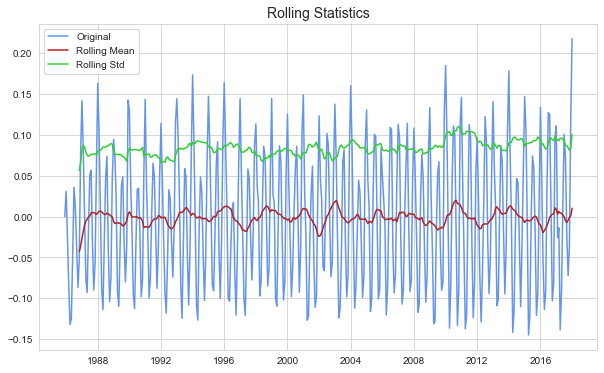

ADF Statistic: -7.213
p-value: 0.0
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [13]:
adfuller_test(df_lsma_sub_df_lsma_ed, window = 12)

The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.

<a id = "12"></a><h1 id="Decomposition"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Decomposition</span></h1>

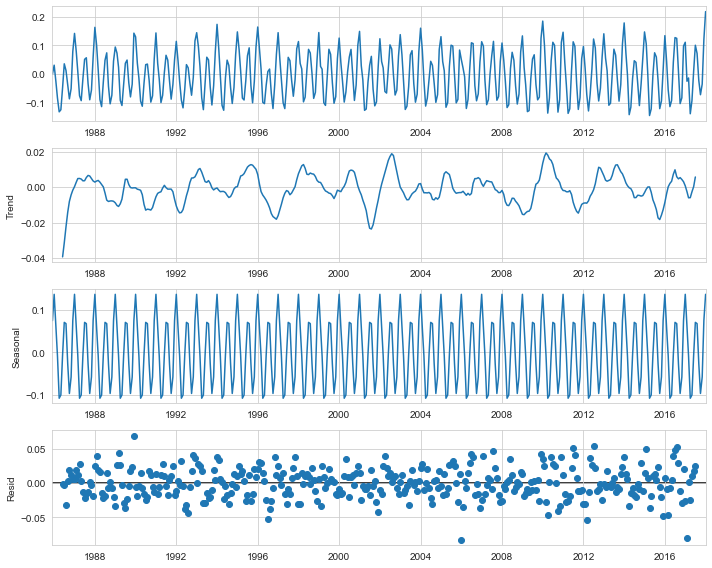

In [14]:
rcParams['figure.figsize']=10,8
df_seasonal_decompose = seasonal_decompose(df_lsma_sub_df_lsma_ed, 
                                           model='duplicative')
df_seasonal_decompose.plot()
plt.show()

<a id = "13"></a><h1 id="ACF & PACF"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">ACF & PACF</span></h1>



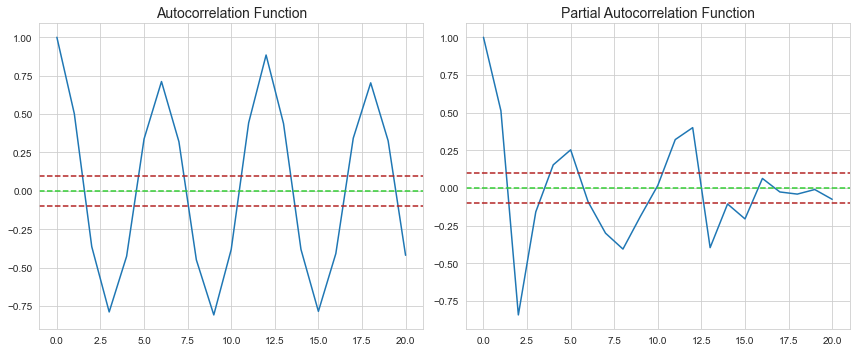

In [15]:
auto_c_f = acf(df_lsma_sub_df_lsma_ed, nlags=20)
partial_auto_c_f = pacf(df_lsma_sub_df_lsma_ed, nlags=20, method='ols')

fig, axs = plt.subplots(1, 2, figsize =(12,5))

plt.subplot(121)
plt.plot(auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Autocorrelation Function', size = 14)            

plt.subplot(122)
plt.plot(partial_auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Partial Autocorrelation Function', size = 14)
            
plt.tight_layout() 

<a id = "14"></a><h1 id="Forecasting Models"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Forecasting Models</span></h1>

<a id = "15"></a><h1 id="Persistence Model"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Persistence Model</p></h1>


In [16]:
values = DataFrame(df_lsma_sub_df_lsma_ed.values)
persistence_df = concat([values.shift(1), values], axis=1)
persistence_df.columns = ['t-1', 't+1']
per_values = persistence_df.values

train = per_values[1:len(per_values)-10] 
test = per_values[len(per_values)-10:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

def persistence(x):
    return x

predictions = []
for i in X_test:
    y_pred = persistence(i)
    predictions.append(y_pred)

persistence_score = mean_squared_error(y_test, predictions)
print('Persistence MSE: {}'.format(round(persistence_score,4)))

Persistence MSE: 0.0084


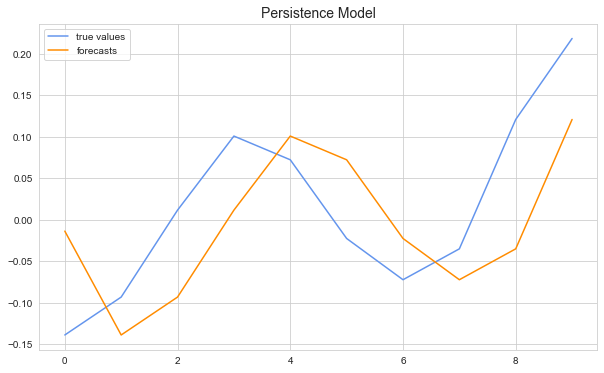

In [17]:
plt.figure(figsize = (10,6))
plt.plot(y_test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("Persistence Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "16"></a><h1 id="Autoregression Model"><p  style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Autoregression Model</p></h1>


In [18]:
ar_values = df_lsma_sub_df_lsma_ed.values
train = ar_values[1:len(ar_values)-10] 
test = ar_values[len(ar_values)-10:]
model = sm.tsa.arima.ARIMA(train, order=(1,1,2))
AR_model  = model.fit()

predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_score = mean_squared_error(test, predictions)
print('AR MSE: {}'.format(round(ar_score,4)))

AR MSE: 0.012


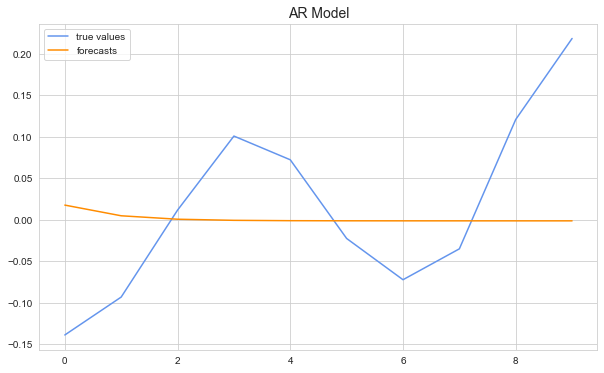

In [19]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "17"></a><h1 id="Moving Average Model"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Moving Average Model</p></h1>

In [20]:
model = model = sm.tsa.arima.ARIMA(train, order=(1,1,2))
MA_model = model.fit()

predictions = MA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_score = mean_squared_error(test, predictions)
print('MA MSE: {}'.format(round(ma_score,4)))

MA MSE: 0.012


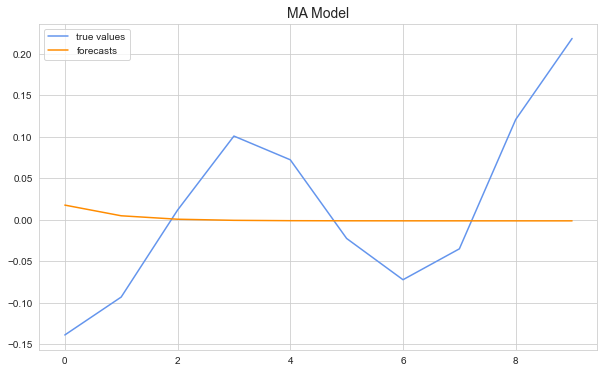

In [21]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "18"></a><h1 id="ARIMA Model"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">ARIMA Model</p></h1>

In [22]:
model = model = sm.tsa.arima.ARIMA(train, order=(1,1,2))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test, predictions)
print('ARIMA MSE: {}'.format(round(arima_score,4)))

ARIMA MSE: 0.012


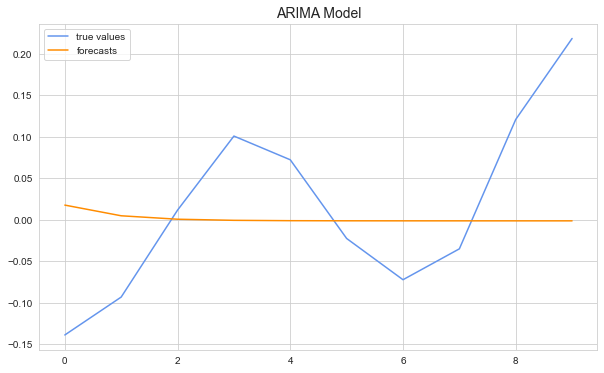

In [23]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "19"></a><h1 id="Mean Squared Errors"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Mean Squared Errors</p></h1>

In [24]:
errors = pd.DataFrame()
errors["Model"] = ["Persistence", "Autoregression", "Moving Average", "ARIMA"]
errors["MSE"] = [persistence_score, ar_score, ma_score, arima_score]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

def coloring_bg(s, min_, max_, cmap='Reds', low=0, high=0):
    color_range = max_ - min_
    norm = colors.Normalize(min_ - (color_range * low), max_ + (color_range * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(), low = 0.1, high = 0.85)

,MSE
Model,
Persistence,0.008401
Autoregression,0.011952
Moving Average,0.011952
ARIMA,0.011952
